# Create the baseline results

In [1]:
import numpy as np
import os
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import r2_score

## Load data via torch dataset

In [2]:
from transformers import GPT2Tokenizer

# only to create a valid dataset
dummy_tokenizer = GPT2Tokenizer.from_pretrained("gpt2", add_special_tokens=True)

/opt/homebrew/Caskroom/miniforge/base/envs/prosody/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from src.data.components.helsinki import HelsinkiProminenceExtractor
from src.data.components.datasets import TokenTaggingDataset
from torch.utils.data import DataLoader

In [4]:
DATA_DIR = "/Users/lukas/Desktop/projects/MIT/MIT_prosody/data/Helsinki"
SAVE_DIR = (
    "/Users/lukas/Desktop/projects/MIT/MIT_prosody/precomputed/predictions/relative"
)

In [6]:
train_extractor = HelsinkiProminenceExtractor(
    DATA_DIR,
    "train_360.txt",
)
train_texts = train_extractor.get_all_texts()
train_prominences = train_extractor.get_all_real_prominence()

dev_extractor = HelsinkiProminenceExtractor(
    DATA_DIR,
    "dev.txt",
)
dev_texts = dev_extractor.get_all_texts()
dev_prominences = dev_extractor.get_all_real_prominence()

test_extractor = HelsinkiProminenceExtractor(
    DATA_DIR,
    "test.txt",
)
test_texts = test_extractor.get_all_texts()
test_prominences = test_extractor.get_all_real_prominence()

print(
    f"train_texts: {len(train_texts)}, dev_texts: {len(dev_texts)}, test_texts: {len(test_texts)}"
)

train_texts: 116263, dev_texts: 5727, test_texts: 4822


In [9]:
train_words = [word for text in train_texts for word in text.split()]
dev_words = [word for text in dev_texts for word in text.split()]
test_words = [word for text in test_texts for word in text.split()]

print(
    f"train_words: {len(train_words)}, dev_words: {len(dev_words)}, test_words: {len(test_words)}"
)

train_words: 2378175, dev_words: 113599, test_words: 102646


In [22]:
GLOBAL_MEAN_PROMINENCE = np.mean([p for ps in train_prominences for p in ps])
GLOBAL_MEAN_PROMINENCE

0.7272557007744903

### Set the dataset to be correct with the task 

In [23]:
word_stats_path = "/Users/lukas/Desktop/projects/MIT/MIT_prosody/data/Helsinki/word_to_stats_uncased.json"

import json

with open(word_stats_path, "r") as f:
    word_stats = json.load(f)

In [24]:
TASK_NAME = "relative"

In [58]:
train_dataset = TokenTaggingDataset(
    input_texts=train_texts,
    targets=train_prominences,
    tokenizer=dummy_tokenizer,
    model_name="gpt2",
    score_last_token=True,
    relative_to_prev=True,
    n_prev=3,
    # relative_to_mean=True,
    # word_stats=word_stats,
)

test_dataset = TokenTaggingDataset(
    input_texts=test_texts,
    targets=test_prominences,
    tokenizer=dummy_tokenizer,
    model_name="gpt2",
    score_last_token=True,
    relative_to_prev=True,
    n_prev=3,
    # relative_to_mean=True,
    # word_stats=word_stats,
)

Preprocessing dataset: 100%|██████████| 4822/4822 [00:01<00:00, 4195.58it/s]


In [59]:
train_sentences = []
train_labels = []
for i in range(len(train_dataset)):
    item = train_dataset.__getitem__(i)
    train_sentences.append(item["input_text"])
    mask = np.array(item["loss_mask"])
    labels = np.array(item["tokenized_labels"])
    valid_labels = np.array(labels[mask == 1])
    train_labels.append(valid_labels)

In [60]:
test_sentences = []
test_labels = []
for i in range(len(test_dataset)):
    item = test_dataset.__getitem__(i)
    test_sentences.append(item["input_text"])
    mask = np.array(item["loss_mask"])
    labels = np.array(item["tokenized_labels"])
    valid_labels = np.array(labels[mask == 1])
    test_labels.append(valid_labels)

### Plot label distribution

In [61]:
train_labels_flat = [el for ls in train_labels for el in ls]
len(train_labels_flat)

2075946

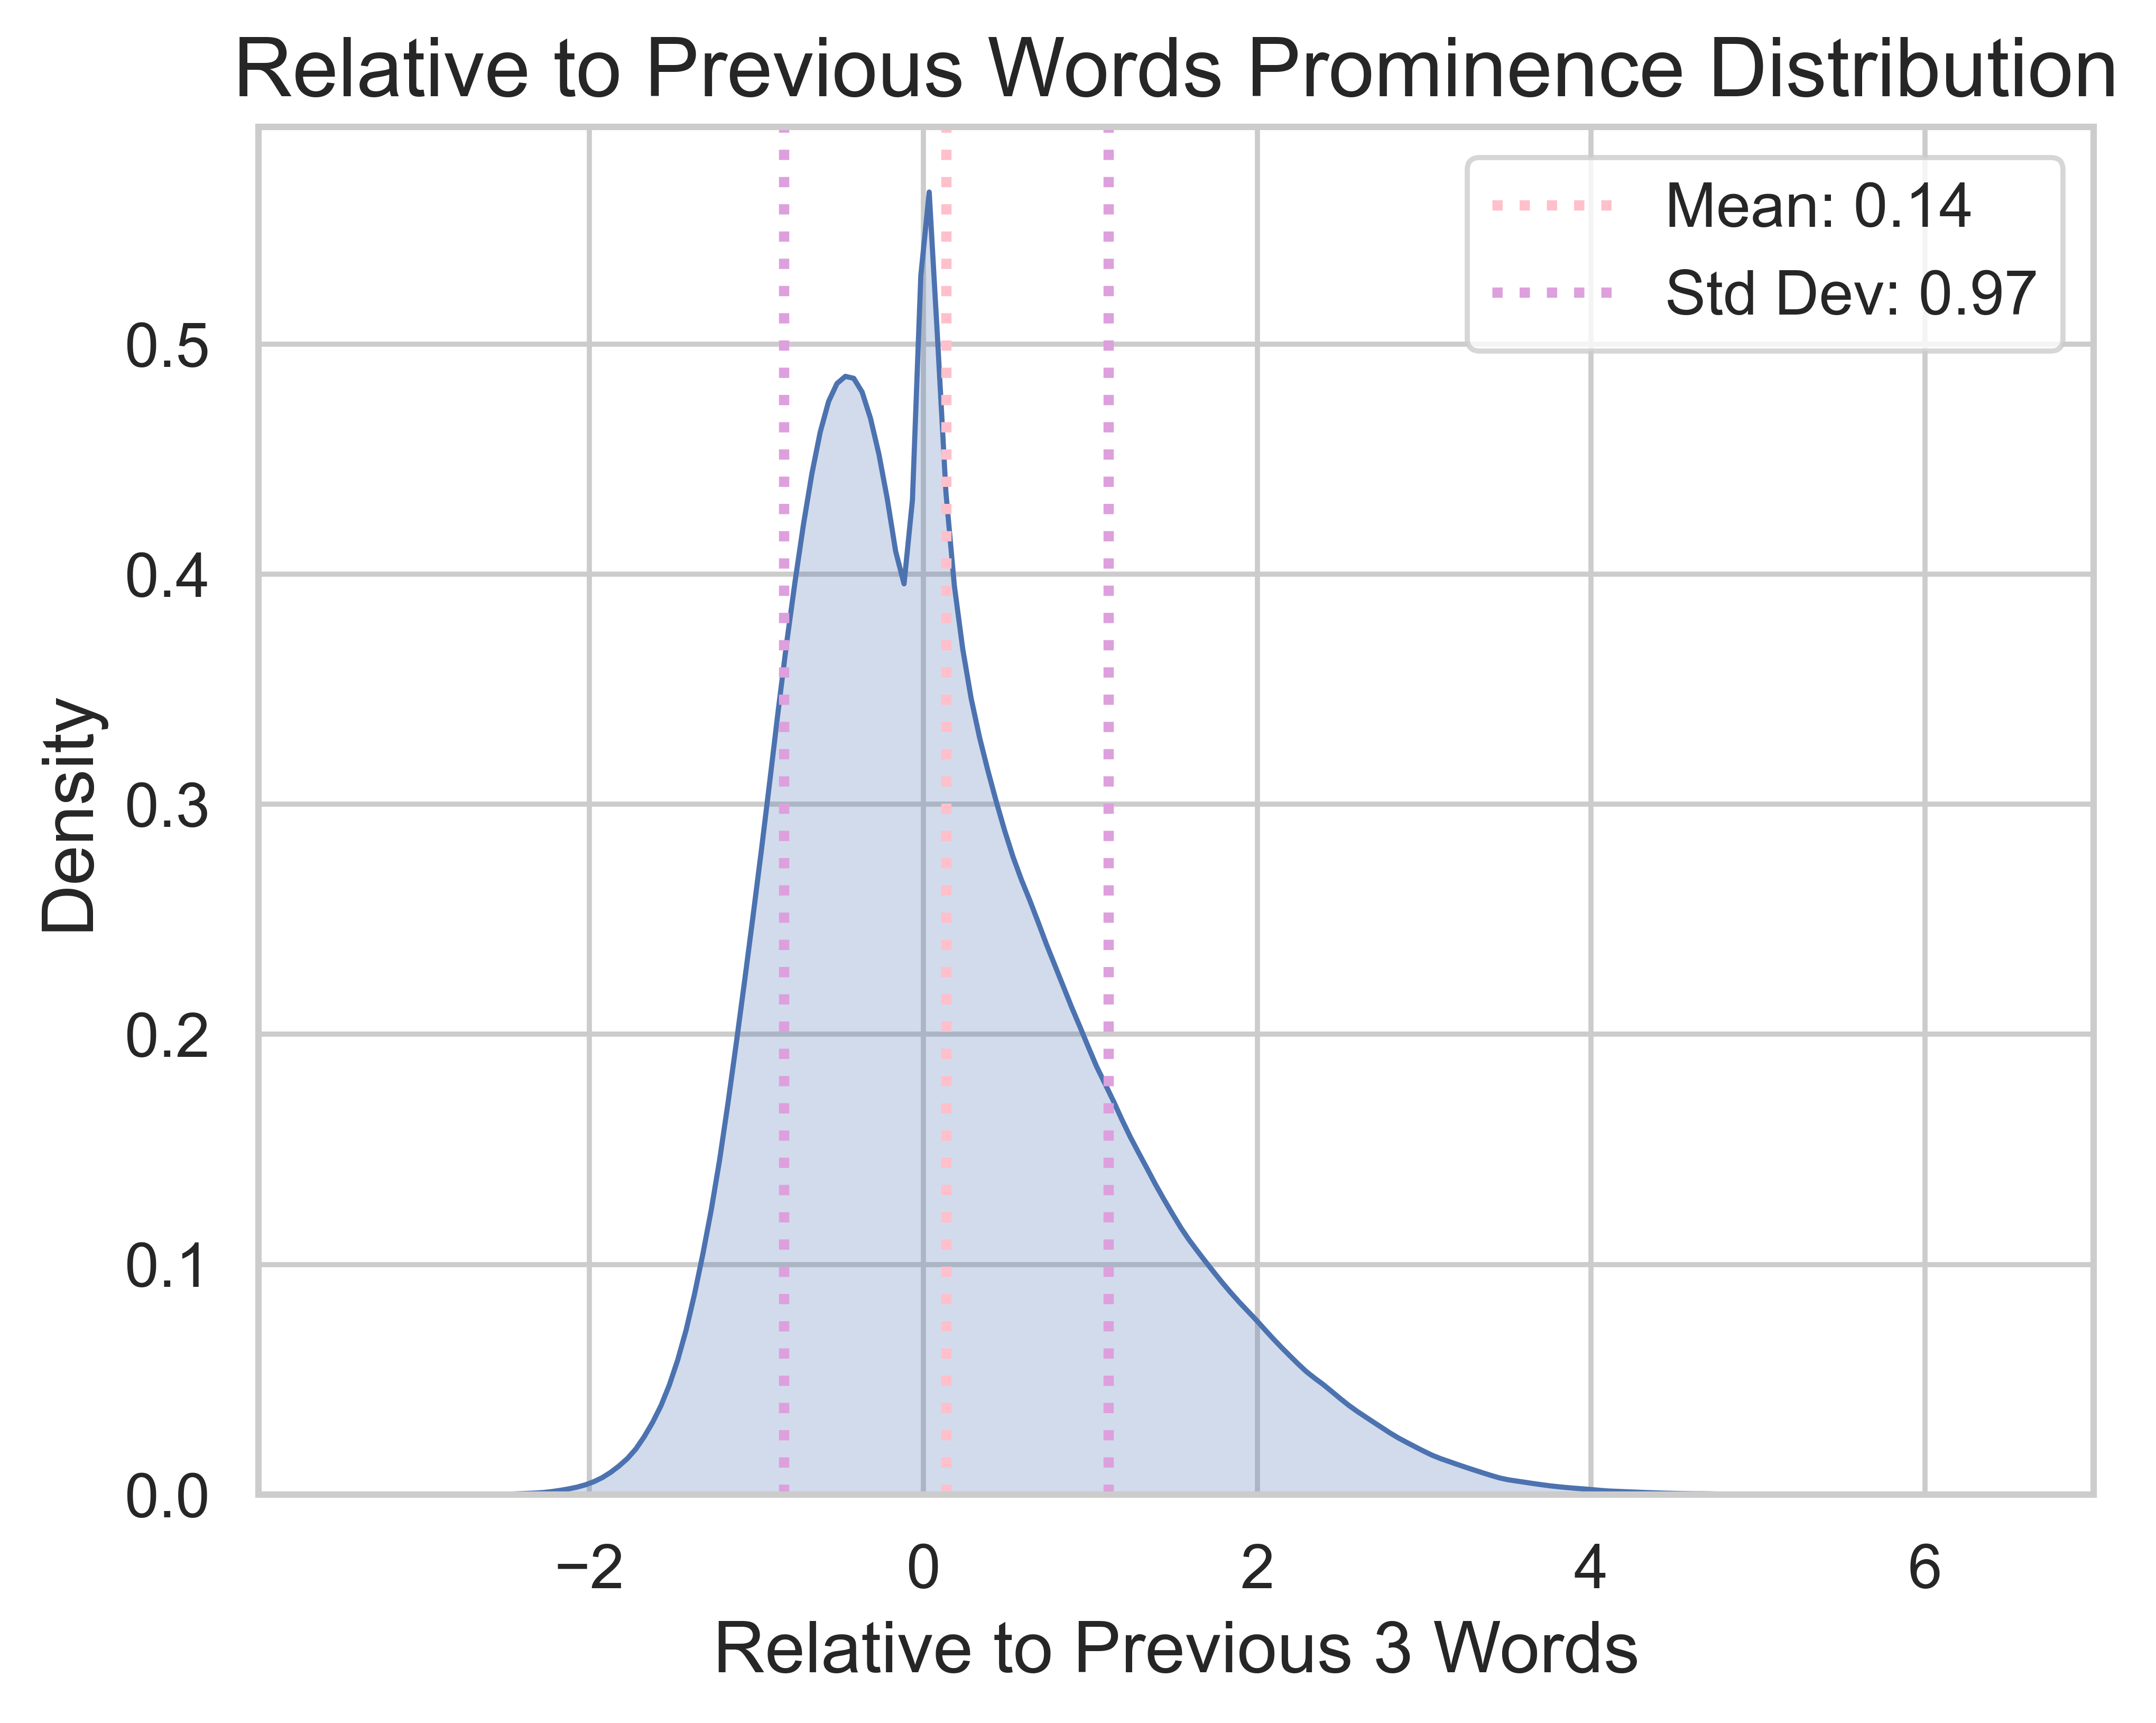

In [63]:
from src.utils.plots import plot_kde

plot_kde(
    data=train_labels_flat,
    label_name="Relative to Previous 3 Words",
    title="Relative to Previous Words Prominence Distribution",
)

### Process data
#### Remove punctuation, lowercase everything 

In [103]:
from src.utils.text_processing import python_lowercase_remove_punctuation

train_sentences = python_lowercase_remove_punctuation(train_sentences)
test_sentences = python_lowercase_remove_punctuation(test_sentences)

train_sentences[:5]

['for man of you your characteristic race here may he hardy sweet gigantic grow here tower proportionate to nature here climb the vast pure spaces unconfined uncheckd by wall or roof here laugh with storm or sun here joy here patiently inure here heed himself unfold himself not others formulas heed here fill his time to duly fall to aid last to disappear to serve',
 'tom the pipers son',
 'tom tom the pipers son stole a pig and away he run the pig was eat and tom was beat and tom ran crying down the street',
 'there was not a worse vagabond in shrewsbury than old barney the piper',
 'he never did any work except to play the pipes and he played so badly that few pennies ever found their way into his pouch']

In [104]:
# create a list of all words in the training set
train_words = [word for sentence in train_sentences for word in sentence.split(" ")]
train_prominences = [prominence for sentence in train_labels for prominence in sentence]

# create a list of all words in the test set
test_words = [word for sentence in test_sentences for word in sentence.split(" ")]
test_prominences = [prominence for sentence in test_labels for prominence in sentence]

print(
    f"Lengths of train and test set: {len(train_words)} and {len(test_words)}, respectively"
)
print(
    f"Lengths of train and test labels: {len(train_prominences)} and {len(test_prominences)}, respectively"
)

Lengths of train and test set: 2075946 and 90050, respectively
Lengths of train and test labels: 2075946 and 90050, respectively


## Simple Models

### Random predictions 

In [105]:
from src.models.baselines.dummy_models import DummyModel

dummy_model = DummyModel(train_prominences, nb_sig=3)
print(f"Dummy model ")

predictions = dummy_model.predict(len(test_prominences))

# compute mse
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_prominences, predictions)
print(f"Mean squared error: {mse}")

# compute r2
r2 = r2_score(test_prominences, predictions)
print(f"R2 score: {r2}")

# compute pearson
pearson = pearsonr(test_prominences, predictions)
print(f"Pearson correlation: {pearson}")

# compute spearman
spearman = spearmanr(test_prominences, predictions)
print(f"Spearman correlation: {spearman}")

# store predictions
dummy_test_predictions = []
for sentence in test_sentences:
    sentence_words = sentence.split(" ")
    sentence_predictions = dummy_model.predict(len(sentence_words))
    dummy_test_predictions.append(sentence_predictions)

# store predictions
import pickle

os.makedirs(f"{SAVE_DIR}/dummy", exist_ok=True)

with open(f"{SAVE_DIR}/dummy/pred_dummy_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(dummy_test_predictions, f)

# store texts
with open(f"{SAVE_DIR}/dummy/texts_dummy_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(test_sentences, f)

# store labels
with open(f"{SAVE_DIR}/dummy/labels_dummy_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(test_labels, f)

Dummy model 
Mean squared error: 1.6442272821286692
R2 score: -2.7066056263367515
Pearson correlation: PearsonRResult(statistic=0.003299191637257945, pvalue=0.32216369013504315)
Spearman correlation: SignificanceResult(statistic=0.002604108204177532, pvalue=0.43454380134951265)


### Avg of all word in corpus

In [106]:
avg_difference = np.mean(train_prominences)
print(f"Average difference in prominence: {avg_difference}")

# compute mse
from sklearn.metrics import mean_squared_error

predictions = [avg_difference] * len(test_prominences)
mse = mean_squared_error(test_prominences, predictions)
print(f"Mean squared error: {mse}")

# compute r2
r2 = r2_score(test_prominences, predictions)
print(f"R2 score: {r2}")

# compute pearson
pearson = pearsonr(test_prominences, predictions)
print(f"Pearson correlation: {pearson}")

# compute spearman
spearman = spearmanr(test_prominences, predictions)
print(f"Spearman correlation: {spearman}")


# store predictions
avg_test_predictions = []
for sentence in test_sentences:
    sentence_words = sentence.split(" ")
    sentence_predictions = [avg_difference] * len(sentence_words)
    avg_test_predictions.append(sentence_predictions)

# store predictions
import pickle

os.makedirs(f"{SAVE_DIR}/avg", exist_ok=True)

with open(f"{SAVE_DIR}/avg/pred_avg_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(avg_test_predictions, f)

# store texts
with open(f"{SAVE_DIR}/avg/texts_avg_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(test_sentences, f)

# store labels
with open(f"{SAVE_DIR}/avg/labels_avg_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(test_labels, f)

Average difference in prominence: 0.011884584322343232
Mean squared error: 0.4436696563565076
R2 score: -0.00017099969104683588
Pearson correlation: PearsonRResult(statistic=nan, pvalue=nan)
Spearman correlation: SignificanceResult(statistic=nan, pvalue=nan)


/opt/homebrew/Caskroom/miniforge/base/envs/prosody/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))
/opt/homebrew/Caskroom/miniforge/base/envs/prosody/lib/python3.9/site-packages/scipy/stats/_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


### Corpus statistics: predict average diff per word 

In [107]:
# collect the words and their prominence scores
word_prominence = {}
for word, prominence in zip(train_words, train_prominences):
    if word not in word_prominence:
        word_prominence[word] = []
    word_prominence[word].append(prominence)

# compute the average prominence score for each word
word_prominence_avg = {}
for word, prominence in word_prominence.items():
    word_prominence_avg[word] = np.mean(prominence)

# for each word in the test set, get the average prominence score
predictions = []
for word in test_words:
    if word in word_prominence_avg:
        predictions.append(word_prominence_avg[word])
    else:
        predictions.append(avg_difference)

# compute mse
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_prominences, predictions)
print(f"Mean squared error: {mse}")

# compute r2
r2 = r2_score(test_prominences, predictions)
print(f"R2 score: {r2}")

# compute pearson
pearson = pearsonr(test_prominences, predictions)
print(f"Pearson correlation: {pearson}")

# compute spearman
spearman = spearmanr(test_prominences, predictions)
print(f"Spearman correlation: {spearman}")

# store predictions
word_test_predictions = []
for sentence in test_sentences:
    sentence_words = sentence.split(" ")
    sentence_predictions = [
        word_prominence_avg[word]
        if word in word_prominence_avg
        else GLOBAL_MEAN_PROMINENCE
        for word in sentence_words
    ]
    word_test_predictions.append(sentence_predictions)

# store predictions
import pickle

os.makedirs(f"{SAVE_DIR}/wordavg", exist_ok=True)

with open(f"{SAVE_DIR}/wordavg/pred_wordavg_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(word_test_predictions, f)

# store texts
with open(f"{SAVE_DIR}/wordavg/texts_wordavg_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(test_sentences, f)

# store labels
with open(f"{SAVE_DIR}/wordavg/labels_wordavg_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(test_labels, f)

Mean squared error: 0.43897993680005554
R2 score: 0.0104011037418692
Pearson correlation: PearsonRResult(statistic=0.12107719394457406, pvalue=3.704234593467805e-291)
Spearman correlation: SignificanceResult(statistic=0.021873486571869175, pvalue=5.2185780087249844e-11)


## GloVe Embedding Baseline
#### Expects Embeddings already downloaded 

In [108]:
weight_dir = "/Users/lukas/Desktop/projects/MIT/MIT_prosody/precomputed/glove"

vocab, embeddings = [], []
with open(os.path.join(weight_dir, "glove.6B.300d.txt"), "rt") as fi:
    full_content = fi.read().strip().split("\n")
for i in range(len(full_content)):
    i_word = full_content[i].split(" ")[0]
    i_embeddings = [float(val) for val in full_content[i].split(" ")[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)

In [109]:
import numpy as np

vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)

print(f"Shapes vocab: {vocab_npa.shape}  embeddings: {embs_npa.shape}")

Shapes vocab: (400000,)  embeddings: (400000, 300)


In [110]:
vocab_npa = np.insert(vocab_npa, 0, "<pad>")
vocab_npa = np.insert(vocab_npa, 1, "<unk>")
print(vocab_npa[:10])

pad_emb_npa = np.zeros((1, embs_npa.shape[1]))  # embedding for '<pad>' token.
unk_emb_npa = np.mean(embs_npa, axis=0, keepdims=True)  # embedding for '<unk>' token.

# insert embeddings for pad and unk tokens at top of embs_npa.
embs_npa = np.vstack((pad_emb_npa, unk_emb_npa, embs_npa))
print(embs_npa.shape)

['<pad>' '<unk>' 'the' ',' '.' 'of' 'to' 'and' 'in' 'a']
(400002, 300)


In [111]:
import torch

my_embedding_layer = torch.nn.Embedding.from_pretrained(
    torch.from_numpy(embs_npa).float()
)

assert my_embedding_layer.weight.shape == embs_npa.shape
print(my_embedding_layer.weight.shape)

torch.Size([400002, 300])


In [112]:
word_to_idx = {word: i for i, word in enumerate(vocab_npa)}
idx_to_word = {i: word for i, word in enumerate(vocab_npa)}

print(word_to_idx["house"])

168


In [113]:
# Create training and test data based on embedding of the word
train_data = []
for word in train_words:
    if word in word_to_idx:
        train_data.append(my_embedding_layer(torch.tensor(word_to_idx[word])))
    else:
        train_data.append(my_embedding_layer(torch.tensor(word_to_idx["<unk>"])))

test_data = []
for word in test_words:
    if word in word_to_idx:
        test_data.append(my_embedding_layer(torch.tensor(word_to_idx[word])))
    else:
        test_data.append(my_embedding_layer(torch.tensor(word_to_idx["<unk>"])))

print(
    f"Lengths of train and test set: {len(train_data)} and {len(test_data)}, respectively"
)

Lengths of train and test set: 2075946 and 90050, respectively


In [114]:
train_data = torch.stack(train_data)
test_data = torch.stack(test_data)

train_data.shape

torch.Size([2075946, 300])

In [115]:
train_labels = torch.tensor(train_prominences)
test_labels = torch.tensor(test_prominences)

train_labels.shape, test_labels.shape

(torch.Size([2075946]), torch.Size([90050]))

### GloVe: sklearn dummy regression

In [116]:
from sklearn.dummy import DummyRegressor

dummy_model = DummyRegressor(strategy="mean")
dummy_model.fit(train_data, train_labels)

predictions = dummy_model.predict(test_data)

# compute mse
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_labels, predictions)
print(f"Mean squared error: {mse}")

Mean squared error: 0.4436696563565076


### GloVe: sklearn linear regression 

In [117]:
from sklearn.linear_model import LinearRegression

linear_model = LinearRegression()
linear_model.fit(train_data, train_labels)

predictions = linear_model.predict(test_data)

# compute mse
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_labels, predictions)
print(f"Mean squared error: {mse}")

# compute r2
r2 = r2_score(test_labels, predictions)
print(f"R2 score: {r2}")

# compute pearson
pearson = pearsonr(test_labels, predictions)
print(f"Pearson correlation: {pearson}")

# compute spearman
spearman = spearmanr(test_labels, predictions)
print(f"Spearman correlation: {spearman}")

Mean squared error: 0.43635575674549526
R2 score: 0.016316831245284047
Pearson correlation: PearsonRResult(statistic=0.12878670215673127, pvalue=0.0)
Spearman correlation: SignificanceResult(statistic=0.04111521813674812, pvalue=5.311267688251681e-35)


### GloVe: sklearn histgradboost

In [118]:
from sklearn.ensemble import HistGradientBoostingRegressor

hist_model = HistGradientBoostingRegressor()
hist_model.fit(train_data, train_labels)

predictions = hist_model.predict(test_data)

# compute mse
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test_labels, predictions)
print(f"Mean squared error: {mse}")

# compute r2
r2 = r2_score(test_labels, predictions)
print(f"R2 score: {r2}")

# compute pearson
pearson = pearsonr(test_labels, predictions)
print(f"Pearson correlation: {pearson}")

# compute spearman
spearman = spearmanr(test_labels, predictions)
print(f"Spearman correlation: {spearman}")

Mean squared error: 0.4326251138724283
R2 score: 0.024726874074193383
Pearson correlation: PearsonRResult(statistic=0.1587705524448899, pvalue=0.0)
Spearman correlation: SignificanceResult(statistic=0.03685064170186745, pvalue=1.9205890415585746e-28)


In [119]:
from tqdm import tqdm

word_test_predictions = []
for sentence in tqdm(
    test_sentences, desc="Predicting test sentences", total=len(test_sentences)
):
    sentence_words = sentence.split(" ")
    # create np array with word embeddings an predict the whole sentence
    sentence_data = []
    for word in sentence_words:
        if word in word_to_idx:
            sentence_data.append(my_embedding_layer(torch.tensor(word_to_idx[word])))
        else:
            sentence_data.append(my_embedding_layer(torch.tensor(word_to_idx["<unk>"])))
    sentence_data = torch.stack(sentence_data)
    sentence_predictions = hist_model.predict(sentence_data)
    word_test_predictions.append(sentence_predictions)

# store predictions
import pickle

os.makedirs(f"{SAVE_DIR}/glove_histgrad", exist_ok=True)

with open(f"{SAVE_DIR}/glove_histgrad/pred_glove_histgrad_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(word_test_predictions, f)

# store texts
with open(f"{SAVE_DIR}/glove_histgrad/texts_glove_histgrad_{TASK_NAME}.pkl", "wb") as f:
    pickle.dump(test_sentences, f)

# store labels
with open(
    f"{SAVE_DIR}/glove_histgrad/labels_glove_histgrad_{TASK_NAME}.pkl", "wb"
) as f:
    pickle.dump(test_prominences, f)

Predicting test sentences: 100%|██████████| 4822/4822 [02:07<00:00, 37.80it/s]
